# Cross-Matching

A common problem in astronomy is matching objects in one catalog to objects in another. Often, these catalogs have different depths (how faint an object is) and angular resolution. In addition, an onject may be brighter in one filter than another and thus not show up in one catalog but will be present in another. 

I'm sure the best way to do this is using a *HIERARCHICAL BAYESIAN PARTITION MODEL*. There is a great review of cross-matching here: https://www.annualreviews.org/doi/pdf/10.1146/annurev-statistics-010814-020231

Here I just want to explore much simpler implementions that astronomers use daily, on smaller catalogs with some very limiting assumptions, such that there each source is unique and you really only want one-to-one matching (two objects in one catalog shouldn't correspond to a single object in the other catalog). This can be problematic when dealing with fuzzy irregularly shaped things like galaxies. My research tends to deal with faint galaxies that mostly look like point sources and so it should be a simpler problem. 

`astropy` has a tool built for this that seems to work great: `match_coordinates_sky` (https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html). It uses a kdtree to calculate distances between all the objects and then finds the closest one. This normally works really well but I think there might be cases where it matches one object to multiple objects in another catalog. 


I want to compare the kdtree method to this: https://en.wikipedia.org/wiki/Hungarian_algorithm which is a combinatorial optimization algorithm that solves the assignment problem. 


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table, hstack, setdiff
from astropy.coordinates import SkyCoord, match_coordinates_sky

from astroquery.sdss import SDSS

from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from getpass import getpass

In [2]:
def query_legacy_survey(ra, dec):
    """Perform a query of the Legacy Survey DR8 in a 6 arcmin region around a coordinate."""
    
    
    # query a 6 arcmin region around a quasar
    query = f"""
    SELECT ra, dec, ls_id, dered_mag_g, snr_g, dered_mag_r, snr_r, dered_mag_z, snr_g, dered_mag_w1, snr_w1, dered_mag_w2, snr_w2, dered_mag_w3, snr_w3, dered_mag_w4, snr_w4
    FROM ls_dr8.tractor_s 
    WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {ra}, {dec}, 0.1)
        AND dered_mag_g < 25
    """
    result = qc.query(sql=query)
    des = convert(result,'pandas')
    return des

In [3]:
def query_sdss(ra, dec, radius=6*u.arcmin, clean=False):
    """ Perform a 5 arcmin cone search around a given coordinate.
    """
    sdss_fields = ['ra', 'dec', 'objID'] + ['dered_' + f for f in 'ugriz'] + ['err_'+ f for f in 'ugriz'] + ['clean']
    coord = SkyCoord(ra, dec, unit='deg')
    sdss_phot = SDSS.query_region(coord, radius=radius, photoobj_fields=sdss_fields)
    
    if clean:
        sdss_phot = sdss_phot[(sdss_phot['clean'] == 1)]
    return sdss_phot.to_pandas()

In [4]:
def kd_xmatch(table1,
           table2,
           ra1_key,
           dec1_key,
           ra2_key,
           dec2_key,
           units='deg',
           max_sep=1.0 * u.arcsec):
    # convert to astropy
    if not isinstance(table1, Table):
        if isinstance(table1, pd.DataFrame):
            table1 = Table.from_pandas(table1)
        else:
            print('table1 must be pandas or astropy table')

    if not isinstance(table2, Table):
        if isinstance(table2, pd.DataFrame):
            table2 = Table.from_pandas(table2)
        else:
            print('table2 must be pandas or astropy table')

    ra1 = np.array(table1[ra1_key])
    dec1 = np.array(table1[dec1_key])
    ra2 = np.array(table2[ra2_key])
    dec2 = np.array(table2[dec2_key])

    c1 = SkyCoord(ra=ra1, dec=dec1, unit=units)
    c2 = SkyCoord(ra=ra2, dec=dec2, unit=units)

    # find the closest match
    idx, d2d, _ = c1.match_to_catalog_sky(c2, nthneighbor=1)

    sep_constraint = d2d < max_sep
    t1_matches = table1[sep_constraint]
    t2_matches = table2[idx[sep_constraint]]

    comb_tab = hstack([t1_matches, t2_matches])
    return comb_tab


In [5]:
ls = query_legacy_survey(36.56028, 0.25827)

In [6]:
sdss = query_sdss(36.56028, 0.25827, clean=True)

In [7]:
len(ls), len(sdss)

(2272, 727)

In [8]:
%%timeit 
kd_xmatch(ls, sdss, ra1_key='ra', dec1_key='dec', ra2_key='ra', dec2_key='dec', max_sep=1.2*u.arcsec)

12.4 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
kd_comb = kd_xmatch(ls, sdss, ra1_key='ra', dec1_key='dec', ra2_key='ra', dec2_key='dec', max_sep=1.2* u.arcsec).to_pandas()

# find the "optimal" radius

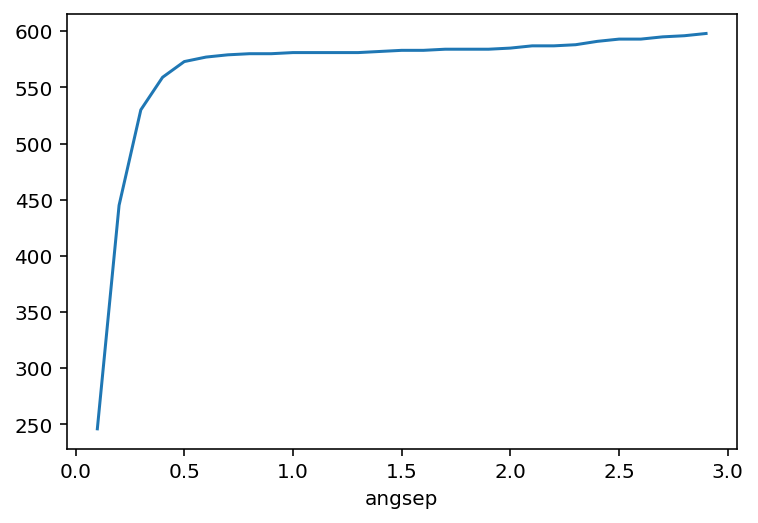

In [10]:
len_list = []
for tol in np.arange(0.1, 3, 0.1):
    ixmatch = kd_xmatch(ls, sdss, ra1_key='ra', dec1_key='dec', ra2_key='ra', dec2_key='dec', max_sep=tol*u.arcsec)
    len_list.append(len(ixmatch))
plt.plot(np.arange(0.1, 3, 0.1), len_list)

plt.xlabel('angsep');

# we can see that there are duplicates however

There are multiple sdss objects assigned to a single legacy survey object

In [11]:
# kd_comb.loc[kd_comb.ls_id.duplicated()]
kd_comb.loc[kd_comb.objID.duplicated()]

,ra_1,dec_1,ls_id,dered_mag_g,snr_g,dered_mag_r,snr_r,dered_mag_z,snr_g.1,dered_mag_w1,...,dered_g,dered_r,dered_i,dered_z,err_u,err_g,err_r,err_i,err_z,clean
1,36.500662,0.179196,8796114777081004,21.9391,28.4489,20.7155,67.4675,19.6283,28.4489,18.7512,...,22.15389,21.28239,20.22922,19.66291,0.694119,0.148183,0.101297,0.056739,0.141361,1
35,36.499514,0.301345,8796114777149305,21.7819,59.1795,21.3172,77.9659,21.0794,59.1795,21.1194,...,21.93579,21.47866,21.31712,21.17338,0.370901,0.080476,0.080248,0.098972,0.366833,1
100,36.502098,0.239773,8796114777147894,22.8023,18.5729,21.5109,48.1576,20.8326,18.5729,20.3436,...,22.39911,21.71372,21.13619,20.87175,0.680230,0.151702,0.114864,0.097682,0.342221,1
138,36.499818,0.286393,8796114777148950,22.4409,21.4995,21.3761,47.6332,20.7215,21.4995,20.0304,...,22.95801,21.49855,21.21678,20.89277,1.007162,0.371055,0.129689,0.134828,0.427122,1
143,36.498367,0.332514,8796114777150026,19.6449,166.5100,19.0786,222.1130,18.6761,166.5100,19.2434,...,19.71073,19.14594,18.93646,18.86296,0.339365,0.034300,0.034538,0.048152,0.148163,1
234,36.499864,0.204234,8796114777147045,23.4875,14.8183,22.0422,46.2237,20.7444,14.8183,NaN,...,23.55971,22.08425,21.26556,21.11843,0.684603,0.250215,0.107217,0.069547,0.247275,1
248,36.499626,0.242926,8796114777147941,19.1815,402.5040,18.8546,494.4800,18.7809,402.5040,20.3354,...,19.23739,18.91268,18.80345,18.80830,0.049355,0.010817,0.010875,0.012224,0.040195,1
305,36.499364,0.331060,8796114777150030,20.7984,163.4420,19.5753,386.9580,18.9104,163.4420,19.7285,...,21.06476,19.76050,19.25580,18.94652,0.580044,0.034504,0.017678,0.015731,0.044259,1
467,36.501154,0.279922,8796114777148768,23.0295,20.8486,22.1112,41.1093,20.8897,20.8486,19.4698,...,22.96980,22.07507,21.14220,20.33427,1.125152,0.229096,0.159168,0.098789,0.214523,1
481,36.501039,0.326852,8796114777149949,23.5701,12.4390,21.8178,50.9288,20.3383,12.4390,19.1228,...,23.69725,22.08315,20.87766,20.45009,0.718292,0.359918,0.140230,0.068694,0.207503,1


# Hungarian method

##  Build the cost matrix. 

Following this:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html?highlight=linear_sum_assignment#scipy.optimize.linear_sum_assignment

In [12]:
def build_cost_matrix(coords1, coords2):
    cost = np.empty((len(coords1), len(coords2)))
    for ii, c1 in enumerate(coords1):
        seps = c1.separation(coords2)
        cost[ii,:] = seps.arcsec
    return cost


In [13]:
coords1 = SkyCoord(ls.ra, ls.dec, unit='deg')
coords2 = SkyCoord(sdss.ra, sdss.dec, unit='deg')
cost = build_cost_matrix(coords1, coords2)

In [14]:
from scipy.optimize import linear_sum_assignment
ls_ind, sdss_ind = linear_sum_assignment(cost)

# there are no duplicates

In [15]:
len(sdss.loc[sdss.objID.duplicated()]), len(ls.loc[ls.ls_id.duplicated()])

(0, 0)

# trim down matches at large distances


In [17]:
len(cost[ls_ind, sdss_ind][cost[ls_ind, sdss_ind] > 1.3])

161

In [18]:
distances = cost[row_ind, col_ind]
len(distances[distances <= 1.3])

NameError: name 'row_ind' is not defined

In [19]:
ls_cut = ls.loc[ls_ind[cost[ls_ind, sdss_ind] <= 1.2]]
sdss_cut = sdss.loc[sdss_ind[cost[ls_ind, sdss_ind] <= 1.2]]

In [20]:
c1 = SkyCoord(sdss_cut.ra, sdss_cut.dec, unit='deg')
c2 = SkyCoord(ls_cut.ra, ls_cut.dec, unit='deg')

h_comb = hstack([Table.from_pandas(sdss_cut), Table.from_pandas(ls_cut)], table_names=['sdss', 'ls'])
h_comb['separation'] = c1.separation(c2).arcsec

In [23]:
def hungarian_xmatch(table1,
                   table2,
                   ra1_key,
                   dec1_key,
                   ra2_key,
                   dec2_key,
                   units='deg',
                   max_sep=1.3):
    
    
    coords1 = SkyCoord(table1.ra, table1.dec, unit='deg')
    coords2 = SkyCoord(table2.ra, table2.dec, unit='deg')
    cost = build_cost_matrix(coords1, coords2)


    tab1_ind, tab2_ind = linear_sum_assignment(cost)
    # attatch dist to table
    dist = cost[tab1_ind, tab2_ind] 
    
    # cut down tables to matches only
    tab1_cut = table1.loc[tab1_ind[dist <= max_sep]]
    tab2_cut = table2.loc[tab2_ind[dist <= max_sep]]
    

    
    h_comb = hstack([Table.from_pandas(tab1_cut), Table.from_pandas(tab2_cut)])#, table_names=['sdss', 'ls'])
    
    dist = dist[dist <= max_sep]
    h_comb['separation'] = dist
    
    return h_comb

# biggest problem is it seems to go at $\mathcal{O}(n^4)$

In [24]:
%%timeit
hungarian_xmatch(ls,
                   sdss,
                   'ra',
                   'dec',
                   'ra',
                   'dec',
                   units='deg',
                   max_sep=1.3)

2.47 s ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
h_comb = hungarian_xmatch(ls,
                   sdss,
                   'ra',
                   'dec',
                   'ra',
                   'dec',
                   units='deg',
                   max_sep=1.3)

In [26]:
h_comb

ra_1,dec_1,ls_id,dered_mag_g,snr_g,dered_mag_r,snr_r,dered_mag_z,snr_g.1,dered_mag_w1,snr_w1,dered_mag_w2,snr_w2,dered_mag_w3,snr_w3,dered_mag_w4,snr_w4,ra_2,dec_2,objID,dered_u,dered_g,dered_r,dered_i,dered_z,err_u,err_g,err_r,err_i,err_z,clean,separation
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
36.5129261878693,0.17319256187970802,8796114777146432,22.6585,18.9914,22.0215,27.1283,21.2828,18.9914,20.5538,9.12335,21.5162,1.65661,19.3034,0.686984,17.5667,0.40718000000000004,36.5128918579488,0.173164077330504,1237663784213349394,23.04481,22.99674,22.36727,21.83386,21.35511,0.5100767,0.2218163,0.1958065,0.1629317,0.4215699,1,0.16058995218513972
36.5720441178225,0.17142113895334501,8796114777146375,22.8404,13.8969,21.1644,50.3371,19.6404,13.8969,18.3612,66.8979,18.8386,19.1307,--,-0.763733,--,-0.148038,36.5719922448043,0.171409090963978,1237663784213414807,23.05024,22.98063,21.35833,20.39073,19.90147,0.6327067,0.26981,0.09985168,0.05942184,0.159224,1,0.19171275948697414
36.5757263186999,0.172811759078642,8796114777146397,20.3839,127.773,19.1673,286.242,18.4342,127.773,18.2318,78.9631,18.5668,25.3563,18.3013,1.6959799999999998,17.9029,0.290242,36.5757052592296,0.17280969569795,1237663784213414422,21.96838,20.59147,19.30949,18.81613,18.46373,0.2281472,0.03247534,0.01687269,0.0152532,0.04112088,1,0.07617678215063302
36.4816088039918,0.19860651318857503,8796114777081470,20.236,111.19200000000001,18.9063,275.14799999999997,18.2169,111.19200000000001,18.2204,67.5638,18.5344,23.0236,19.5279,0.490957,17.0094,0.6264770000000001,36.4815924989448,0.198593957465244,1237663784213349007,23.6487,20.5079,19.05224,18.61137,18.26735,1.289868,0.04386581,0.0193231,0.01852017,0.05167355,1,0.07408460212105342
36.4863661628912,0.20345156613089602,8796114777081580,19.8825,177.25599999999997,18.5675,422.12,17.8513,177.25599999999997,17.8121,109.649,18.1773,34.8251,20.9832,0.138266,17.2922,0.51888,36.4863608997441,0.203447126845105,1237663784213348564,22.41909,20.03286,18.64617,18.16534,17.77842,0.4264582,0.02592953,0.01284875,0.01167008,0.02972186,1,0.02478715068884202
36.48081285709279,0.218895482933472,8796114777081958,20.1784,101.304,19.599,134.157,19.1835,101.304,19.354,26.5592,19.9615,6.7735,18.0258,2.0882099999999997,16.0929,1.53435,36.4808340221731,0.218891362043089,1237666408458355003,21.75552,20.71475,20.24763,19.87357,19.78966,0.203845,0.03223071,0.03068074,0.03148939,0.1205633,1,0.07762453397547955
36.5098214746857,0.21047659773255703,8796114777147238,21.7959,30.0751,20.0594,106.214,19.0913,30.0751,18.4488,62.8594,19.0247,16.605,17.6461,3.0326,15.9852,1.7180099999999998,36.5098124659802,0.210466112932789,1237666408458420662,23.29404,22.16904,20.39894,19.76771,19.39493,0.7532368,0.113201,0.03678584,0.03023096,0.09237197,1,0.04976428145420891
36.5071986647929,0.2466880543516,8796114777148024,19.8685,104.90299999999999,18.5798,255.255,17.7933,104.90299999999999,17.4675,112.882,17.7973,37.6649,16.857,4.939690000000001,16.167,1.26065,36.5072051834111,0.246687428341051,1237666408458420645,21.74717,20.28666,19.12415,18.65168,18.20867,0.3739731,0.03793101,0.02216191,0.02075819,0.05844677,1,0.023574773855430435
36.4895085249725,0.25885027732989396,8796114777082795,20.6856,131.953,19.2439,347.11300000000006,18.5815,131.953,18.2818,79.5988,18.6508,24.8706,--,-0.27970900000000004,18.7723,0.135376,36.4895099837474,0.25884695666742,1237666408458420571,23.19223,20.87834,19.40421,18.93906,18.83727,0.6570179,0.0367284,0.01687687,0.01562608,0.05402448,1,0.013057026823761227


In [27]:
k_comb = Table.from_pandas(kd_comb)

In [28]:
setdiff(h_comb, k_comb, keys='objID')

ra_1,dec_1,ls_id,dered_mag_g,snr_g,dered_mag_r,snr_r,dered_mag_z,snr_g.1,dered_mag_w1,snr_w1,dered_mag_w2,snr_w2,dered_mag_w3,snr_w3,dered_mag_w4,snr_w4,ra_2,dec_2,objID,dered_u,dered_g,dered_r,dered_i,dered_z,err_u,err_g,err_r,err_i,err_z,clean,separation
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64


In [29]:
setdiff(k_comb, h_comb, keys='objID')

ra_1,dec_1,ls_id,dered_mag_g,snr_g,dered_mag_r,snr_r,dered_mag_z,snr_g.1,dered_mag_w1,snr_w1,dered_mag_w2,snr_w2,dered_mag_w3,snr_w3,dered_mag_w4,snr_w4,ra_2,dec_2,objID,dered_u,dered_g,dered_r,dered_i,dered_z,err_u,err_g,err_r,err_i,err_z,clean
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
36.490467010425604,0.19263492699554,8796114777081358,23.2975,17.7884,21.8693,53.8603,19.7249,17.7884,19.9435,17.191,21.1041,2.58443,--,-1.21058,--,-3.28935,36.4904837979691,0.192687768813514,1237663784213348645,23.96361,23.28752,22.20591,20.58668,19.84452,0.5999944,0.1970156,0.1128058,0.03888783,0.08249077,1
36.5006616716598,0.17919569874900199,8796114777146559,21.9381,28.4676,20.7152,67.4717,19.628,28.4676,18.7504,44.3373,19.2273,12.5698,18.657,1.14636,15.5035,2.65548,36.5006389897375,0.179155083691113,1237663784213349068,23.06528,22.15389,21.28239,20.22922,19.66291,0.6941188,0.148183,0.1012971,0.05673852,0.1413608,1
36.5006616943292,0.179195656908156,8796114777081004,21.9391,28.4489,20.7155,67.4675,19.6283,28.4489,18.7512,44.31100000000001,19.2142,12.722999999999999,18.6153,1.1913799999999999,15.3919,2.93995,36.5006389897375,0.179155083691113,1237663784213349068,23.06528,22.15389,21.28239,20.22922,19.66291,0.6941188,0.148183,0.1012971,0.05673852,0.1413608,1
36.6203936527671,0.188862700121596,8796114777146767,22.3166,41.398999999999994,21.9021,48.1886,21.6512,41.398999999999994,21.9388,2.75975,--,-0.24732600000000002,19.682000000000002,0.491555,--,-0.876959,36.6203647093685,0.188860308022079,1237663784213414543,23.04712,22.21534,21.67098,21.57432,21.42331,0.3849266,0.08983388,0.0797768,0.100335,0.3521973,1
36.6093818610195,0.173613902602124,8796114777146463,24.651,5.28937,22.8912,25.9905,21.3457,5.28937,--,-0.303611,--,-1.31017,--,-0.700639,--,-0.797403,36.6093694326105,0.173617106086276,1237663784213414863,25.07864,24.19578,22.57422,21.42224,20.66096,0.7375602,0.4927847,0.2041776,0.1042307,0.2269209,1


In [30]:
setdiff(k_comb, h_comb, keys='ls_id')

ra_1,dec_1,ls_id,dered_mag_g,snr_g,dered_mag_r,snr_r,dered_mag_z,snr_g.1,dered_mag_w1,snr_w1,dered_mag_w2,snr_w2,dered_mag_w3,snr_w3,dered_mag_w4,snr_w4,ra_2,dec_2,objID,dered_u,dered_g,dered_r,dered_i,dered_z,err_u,err_g,err_r,err_i,err_z,clean
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
36.5006616943292,0.179195656908156,8796114777081004,21.9391,28.4489,20.7155,67.4675,19.6283,28.4489,18.7512,44.31100000000001,19.2142,12.722999999999999,18.6153,1.1913799999999999,15.3919,2.93995,36.5006389897375,0.179155083691113,1237663784213349068,23.06528,22.15389,21.28239,20.22922,19.66291,0.6941188,0.148183,0.1012971,0.05673852,0.1413608,1
36.490467010425604,0.19263492699554,8796114777081358,23.2975,17.7884,21.8693,53.8603,19.7249,17.7884,19.9435,17.191,21.1041,2.58443,--,-1.21058,--,-3.28935,36.4904837979691,0.192687768813514,1237663784213348645,23.96361,23.28752,22.20591,20.58668,19.84452,0.5999944,0.1970156,0.1128058,0.03888783,0.08249077,1
36.4998639869744,0.20423417588123602,8796114777081643,23.4871,14.8207,22.0421,46.226000000000006,20.7445,14.8207,21.752,3.3196800000000004,--,-0.6811689999999999,18.779,1.16049,15.0367,4.2251199999999995,36.4998376380956,0.204245198016895,1237663784213349384,24.15334,23.55971,22.08425,21.26556,21.11843,0.6846034,0.2502148,0.1072172,0.06954704,0.2472752,1
36.5020979446188,0.23977317293242603,8796114777082371,22.7984,18.602999999999998,21.5088,48.1472,20.8299,18.602999999999998,20.3566,11.6517,20.3532,5.09371,24.0909,0.008309,--,-0.204936,36.5022098333128,0.239791660932472,1237666408458420623,23.11041,22.39911,21.71372,21.13619,20.87175,0.6802299,0.1517017,0.1148643,0.09768248,0.3422213,1
36.499625983809,0.24292638977962602,8796114777082430,19.1815,402.50300000000004,18.8546,494.47900000000004,18.7809,402.50300000000004,20.3546,12.0207,20.7295,3.72986,18.4144,1.59338,16.5669,1.0303799999999999,36.49960730331,0.242945895380237,1237666408458420343,20.16061,19.23739,18.91268,18.80345,18.8083,0.04935533,0.01081676,0.01087548,0.01222387,0.04019464,1
36.499818247722104,0.28639249488905394,8796114777083381,22.4405,21.4989,21.3756,47.6332,20.7207,21.4989,20.3113,12.0143,20.5237,4.33809,--,-0.43288000000000004,--,-0.306026,36.4998832323273,0.286379935741156,1237666408458420613,23.39211,22.95801,21.49855,21.21678,20.89277,1.007162,0.371055,0.1296892,0.1348279,0.4271219,1
36.499514360117395,0.30134472929503897,8796114777083719,21.7817,59.1863,21.316999999999997,77.9746,21.0789,59.1863,21.2437,5.20561,21.4508,1.8862900000000002,--,-1.47846,15.1062,3.91932,36.4995011702588,0.301341539332781,1237666408458420604,22.56043,21.93579,21.47866,21.31712,21.17338,0.3709008,0.08047631,0.08024847,0.09897158,0.3668327,1
36.4993643320026,0.331059749891623,8796114777084444,20.7984,163.442,19.5753,386.96,18.9104,163.442,19.7236,21.6372,20.6282,4.13529,--,-0.434399,--,-3.35788,36.4993374960736,0.33105653231697,1237666408458420606,23.44987,21.06476,19.7605,19.2558,18.94652,0.5800437,0.03450369,0.01767791,0.01573149,0.04425908,1
36.6093818610195,0.173613902602124,8796114777146463,24.651,5.28937,22.8912,25.9905,21.3457,5.28937,--,-0.303611,--,-1.31017,--,-0.700639,--,-0.797403,36.6093694326105,0.173617106086276,1237663784213414863,25.07864,24.19578,22.57422,21.42224,20.66096,0.7375602,0.4927847,0.2041776,0.1042307,0.2269209,1


In [48]:
kd_comb

,ra_1,dec_1,ls_id,dered_mag_g,snr_g,dered_mag_r,snr_r,dered_mag_z,snr_g.1,dered_mag_w1,...,dered_g,dered_r,dered_i,dered_z,err_u,err_g,err_r,err_i,err_z,clean
0,36.500662,0.179196,8796114777146559,21.9381,28.4676,20.7152,67.4717,19.6280,28.4676,18.7504,...,22.15389,21.28239,20.22922,19.66291,0.694119,0.148183,0.101297,0.056739,0.141361,1
1,36.500662,0.179196,8796114777081004,21.9391,28.4489,20.7155,67.4675,19.6283,28.4489,18.7512,...,22.15389,21.28239,20.22922,19.66291,0.694119,0.148183,0.101297,0.056739,0.141361,1
2,36.512926,0.173193,8796114777146432,22.6585,18.9914,22.0215,27.1283,21.2828,18.9914,20.5538,...,22.99674,22.36727,21.83386,21.35511,0.510077,0.221816,0.195806,0.162932,0.421570,1
3,36.572044,0.171421,8796114777146375,22.8404,13.8969,21.1644,50.3371,19.6404,13.8969,18.3612,...,22.98063,21.35833,20.39073,19.90147,0.632707,0.269810,0.099852,0.059422,0.159224,1
4,36.575726,0.172812,8796114777146397,20.3839,127.7730,19.1673,286.2420,18.4342,127.7730,18.2318,...,20.59147,19.30949,18.81613,18.46373,0.228147,0.032475,0.016873,0.015253,0.041121,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,36.586756,0.339842,8796114777150242,22.2867,34.7805,21.6655,51.7165,21.3679,34.7805,22.7370,...,22.14455,21.40035,21.50740,21.34684,0.595190,0.112495,0.090671,0.156799,0.518497,1
577,36.582364,0.350782,8796114777150470,21.0276,101.7230,19.7357,257.5580,19.0064,101.7230,18.3371,...,21.04740,19.76275,19.23110,18.91611,0.297773,0.046772,0.024311,0.021412,0.066226,1
578,36.606350,0.344817,8796114777150341,22.8287,25.7419,21.9410,50.1778,21.3312,25.7419,20.6511,...,22.97881,22.14041,21.66476,20.69074,0.755382,0.163047,0.115789,0.104689,0.205420,1
579,36.627331,0.326472,8796114777149939,23.2210,18.2145,21.9035,51.9993,21.1242,18.2145,21.3472,...,23.13657,21.71971,21.11300,21.24463,0.765351,0.244668,0.109120,0.089527,0.442577,1


In [31]:
sdss_dups = kd_comb.loc[kd_comb.objID.duplicated()]

In [51]:
kd_comb.drop_duplicates(subset='objID', keep='first', inplace=True)

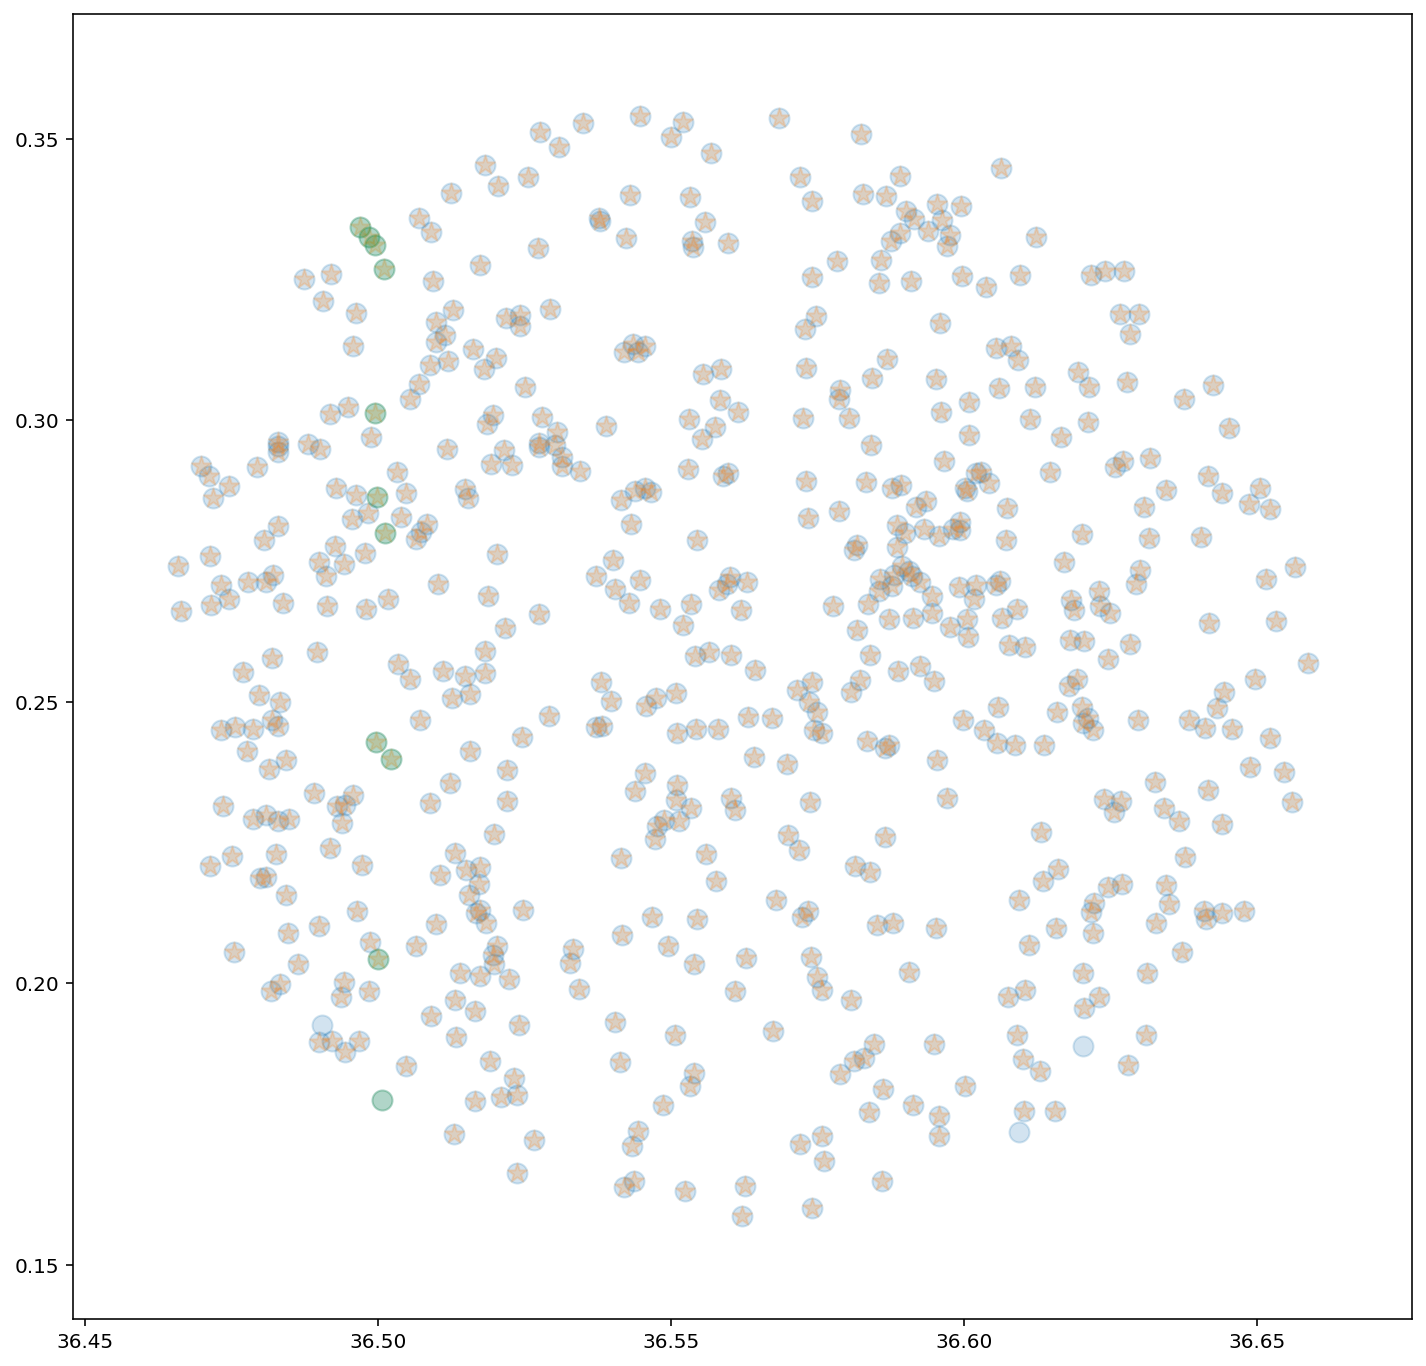

In [53]:
plt.figure(figsize=(12,12))
plt.scatter(kd_comb['ra_1'], kd_comb['dec_1'], s=100, alpha=0.2)
plt.scatter(h_comb['ra_1'], h_comb['dec_1'], s=100, alpha=0.2, marker='*')
plt.scatter(sdss_dups['ra_1'], sdss_dups['dec_1'], s=100, alpha=0.2);

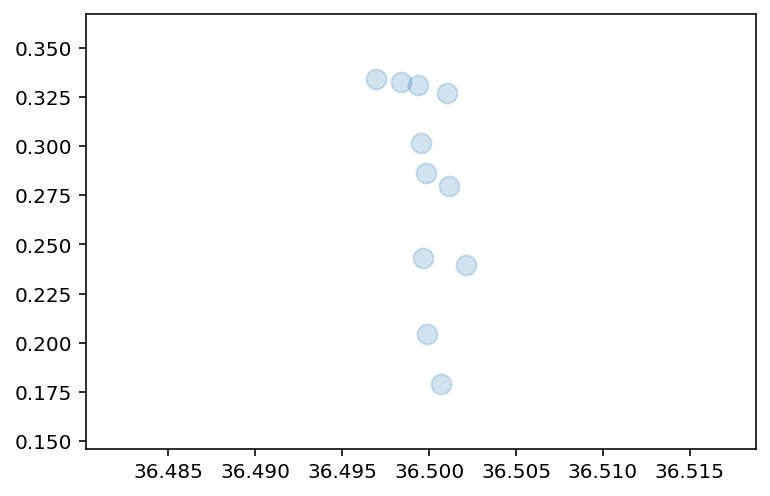

In [54]:
plt.scatter(sdss_dups['ra_1'], sdss_dups['dec_1'], s=100, alpha=0.2);

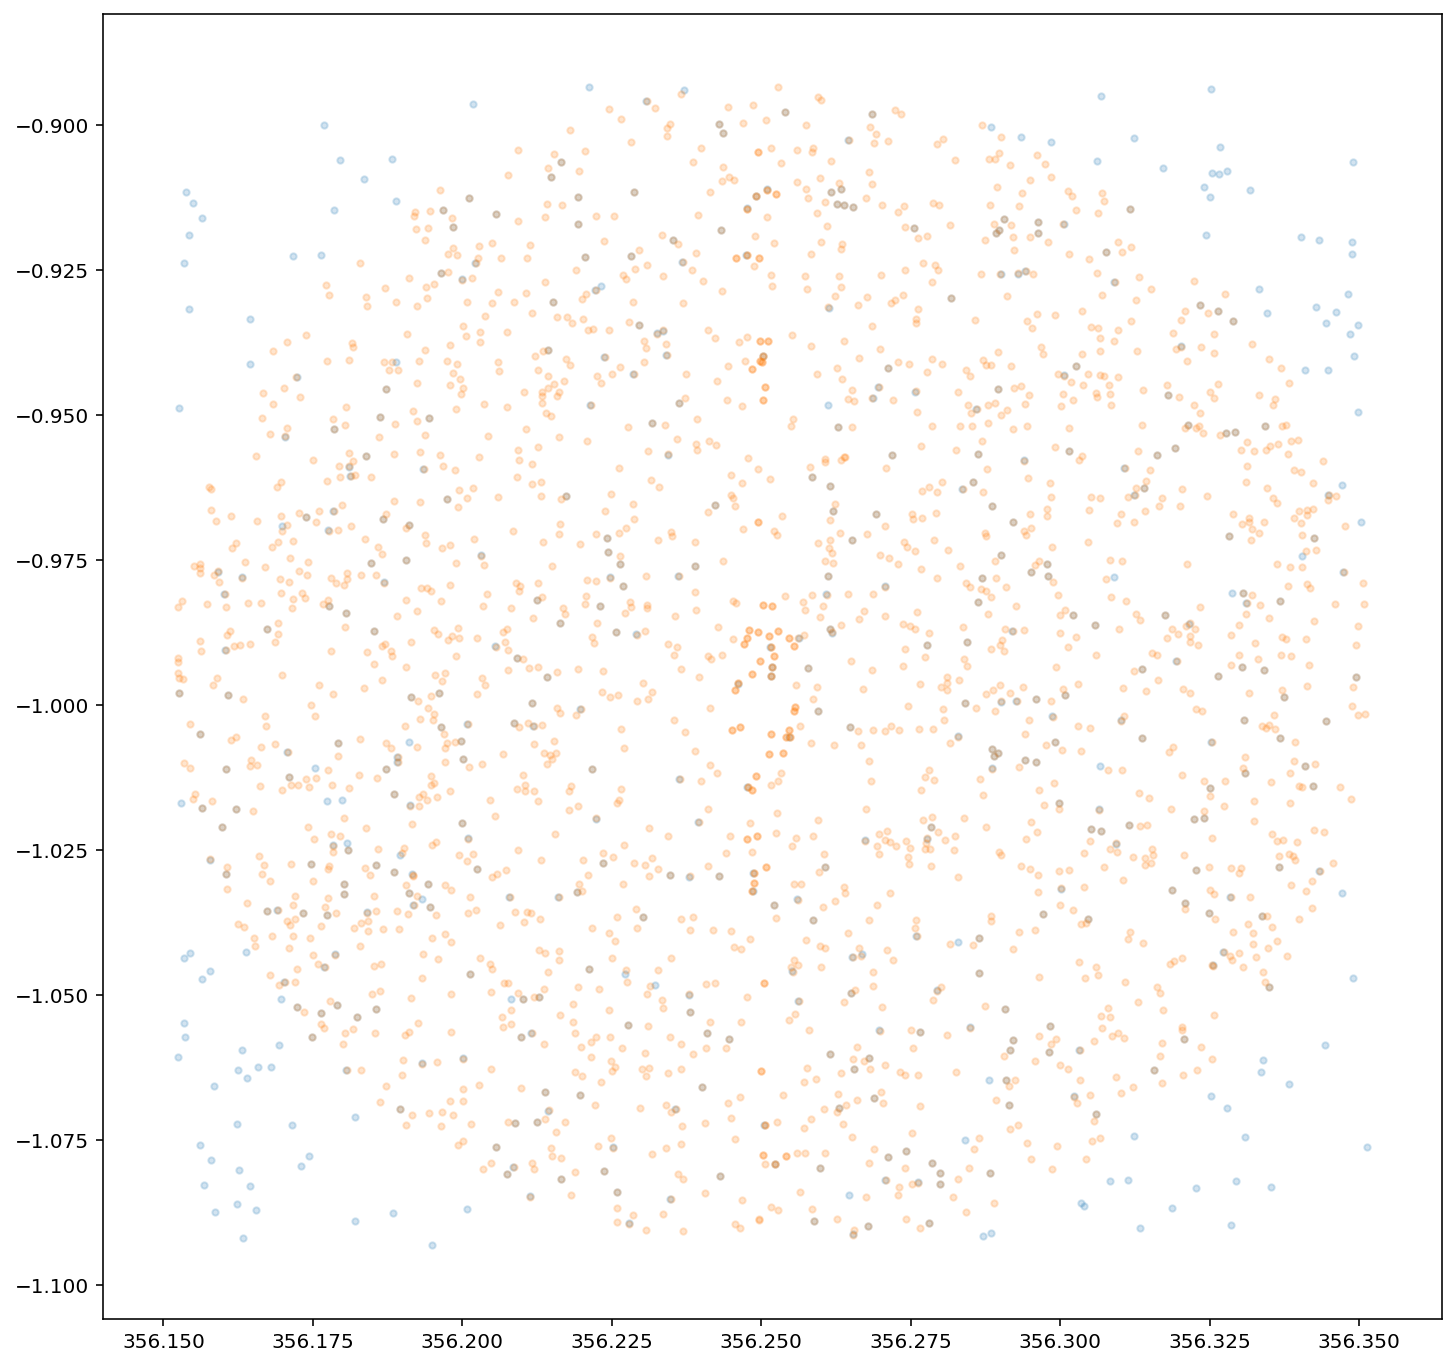

In [43]:
#ls2 = query_legacy_survey(356.2518, -0.99335)
#sdss2 = query_sdss(356.2518, -0.99335, clean=1)

plt.figure(figsize=(12,12))
plt.scatter(sdss2['ra'], sdss2['dec'], s=10, alpha=0.2)
plt.scatter(ls2['ra'], ls2['dec'], s=10, alpha=0.2);